In [1]:
# notebook setup

%load_ext autoreload
%autoreload 2

from irt2 import ipynb
ipynb.setup_logging()

irt2.ipynb - test


In [2]:
import irt2
from irt2.create import EID, Mention

from pathlib import Path
from pprint import pprint

from ktz.collections import ryaml

import numpy as np
import matplotlib.pyplot as plt


config = ryaml(
    irt2.ENV.DIR.CONF / 'create' / 'cde.yaml',
    irt2.ENV.DIR.CONF / 'create' / 'cde-xs.yaml'
)

pprint(config)

{'concept relations': ['P1412:languages spoken, written, or signed',
                       'P27:country of citizenship',
                       'P30:continent'],
 'exclude relations': [],
 'graph loader': 'codex',
 'graph loader args': ['lib/codex/data/triples/codex-m/train.txt',
                       'lib/codex/data/triples/codex-m/valid.txt',
                       'lib/codex/data/triples/codex-m/test.txt'],
 'graph loader kwargs': {'f_ent2id': 'lib/codex/data/entities/en/entities.json',
                         'f_rel2id': 'lib/codex/data/relations/en/relations.json'},
 'graph name': 'CodEx-M',
 'include relations': ['P1412:languages spoken, written, or signed',
                       'P27:country of citizenship',
                       'P30:continent',
                       'P106:occupation',
                       'P19:place of birth'],
 'name': 'IRT2/CDE-XS',
 'prune mentions': 5,
 'seed': 5012022,
 'separator': '|',
 'source graph': 'Wikidata',
 'source matches': 'data/source

In [3]:
from ktz.string import args_hash
from ktz.functools import Cascade

# set up cascade for development

def setup_cascade(config, keys):
    hash = args_hash(config)
    print(hash)

    prefix = 'create.ipynb'

    cascade = {name: f'{prefix}-{hash}-{name}' for name in keys}
    run = Cascade(path=irt2.ENV.DIR.CACHE, **cascade)

    return run


run = setup_cascade(config, keys=['matches', 'mentions', 'split'])

7737d719ea03b856b7e685f126d6abfdb2b97b8a3d36849b88303b5e
ktz.functools - cascade: will resume at mentions


In [4]:
from irt2 import create


@run.cache('matches')
def load_matches():

    matches = create.index_matches(
        irt2.ENV.DIR.ROOT / config['source matches'],
        None,
    )

    print('\nmatch index:')
    print(f'  total: {len(matches.flat)}')
    print(f'  pages: {len(matches.keys("page"))}')
    print(f'   eids: {len(matches.keys("eid"))}')

    return matches


matches = load_matches()

ktz.functools - cascade: skipping matches


In [5]:
# plot how matches distribute over entities

def plot_dist(
    y,
    title: str,
    subtitle: str,
    filenames: list[Path] = None,
):
    fig, ax = plt.subplots()
    fig.suptitle(title)

    ax.set_title(subtitle, color='#999')
    ax.set_yscale('log')

    ax.plot(np.arange(len(y)), y, color='#666')

    if filenames:
        for filename in filenames:
            fig.savefig(filename)


@run.when('matches')
def plot_distribution_idx(index, **kwargs):

    lens = {}
    for eid in index.keys('eid'):
        n = len(index.dis(eid=eid))
        lens[eid] = n

    lens = sorted(((n, eid) for eid, n in lens.items()), reverse=True)
    y = np.array([n for n, _ in lens])

    plot_dist(y=y, **kwargs)


plot_distribution_idx(
    index=matches,
    title="Matches Count",
    subtitle="{config['source graph']} ({config['source name']})",
)

In [6]:
from ktz.dataclasses import Index
from dataclasses import dataclass

print(f"\nmapping EIDS to mentions")
print(f"pruning at threshold: {config['prune mentions']}")


@dataclass
class Mentions:

    eid2mentions: dict[EID, dict[Mention, int]]
    norm2mentions: dict[str, str]


@run.cache('mentions')
def get_mentions(index: Index, prune: int):
    mentions = create.get_mentions(index=index, prune=prune)
    print(f'retained {len(mentions.eid2mentions)} mentions')
    return mentions


mentions = get_mentions(
    index=matches,
    prune=config['prune mentions'],
)


mapping EIDS to mentions
pruning at threshold: 5
ktz.functools - cascade: loading mentions from create.ipynb-7737d719ea03b856b7e685f126d6abfdb2b97b8a3d36849b88303b5e-mentions


In [7]:
# some example mentions

@run.when('mentions')
def print_mention_counts(mentions, eid):
    counts = mentions.eid2mentions[eid]

    for mention, count in sorted(counts.items(), key=lambda t: t[1], reverse=True):
        print(f"{count:5d} {mention}" )
    print()

print_mention_counts(mentions=mentions, eid='Q11708')
print_mention_counts(mentions=mentions, eid='Q49297')
print_mention_counts(mentions=mentions, eid='Q21077')

10036 southeast asia
  165 southeast
  125 south east asia
   32 southeast asian
   19 south east asian
   14 southeast asian countries
   13 southeastern asia
    9 southeast asian region
    8 sea
    5 southeastern
    5 south east

 9807 native american
 5211 native americans
 1640 indian
 1272 indians
 1106 american indian
  620 native
  424 american indians
  114 native americans in the united states
  106 american
   49 natives
   48 indigenous
   36 native american tribes
   34 indigenous peoples
   30 indian tribes
   24 united states
   22 tribe
   20 indigenous people
   18 native peoples
   16 tribal
   14 native american tribe
   12 american indian or alaska native
   10 native american people
   10 native american peoples
    9 aboriginal american
    9 native american indians
    9 indian affairs
    8 american indian and alaska native
    7 native indian
    7 native tribes
    7 native indians
    7 tribes
    6 first nations
    6 native american indian
    6 bands
  

In [8]:
# entities with most mentions

@run.when('mentions', 'matches')
def match_examples(matches, mentions):
    for eid, mdic in sorted(mentions.eid2mentions.items(), key=lambda t: len(t[1]), reverse=True)[:20]:
        print(len(mdic), eid, list(matches.get(eid=eid))[0].entity)


match_examples(matches, mentions)

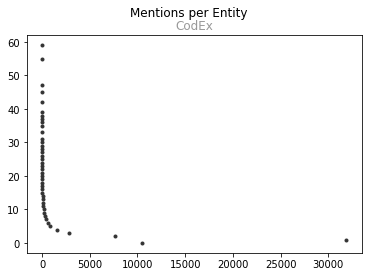

In [9]:
from collections import Counter


@run.when('mentions')
def plot_mention_counts(mentions, title, subtitle, **kwargs):
    counts = Counter()
    for countdic in mentions.eid2mentions.values():
        counts[len(countdic)] += 1

    y, x = zip(*sorted(counts.items()))

    fig, ax = plt.subplots()
    fig.suptitle(title)
    ax.set_title(subtitle, color='#999')

    ax.scatter(x, y, **kwargs)


plot_mention_counts(
    mentions=mentions,
    title="Mentions per Entity",
    subtitle=config['source name'],
    color='#333',
    marker='.',
)

In [10]:
from irt2.graph import Graph
from irt2.graph import load_graph


graph = load_graph(
    config['graph loader'],
    config['graph name'],
    *[irt2.ENV.DIR.ROOT / path for path in config['graph loader args']],
    **{k: irt2.ENV.DIR.ROOT / path for k, path in config['graph loader kwargs'].items()},
)


print(graph.description)

IRT2 GRAPH: CodEx-M
  nodes: 17050
  edges: 206205 (51 types)
  degree:
    mean 24.19
    median 13



In [89]:
# split triples/vertices/mentions:
#  - select all mentions of concept entities
#  - shuffle and split remaining mentions randomly (cw/ow-validation/ow-test)
#  - assign vertices based on mention split to be either cw or ow
#  - assign triples based on vertex split

from irt2.create import Split
from IPython.core.debugger import set_trace

def create_split(config, graph, mentions):

    ratio_train = config['target mention split']
    print(f"targeting {int(ratio_train * 100)}% closed-world mentions")

    ratio_val = config['target validation split']
    print(f"using {int(ratio_val * 100)}% open-world mentions for validation")

    split = Split.create(
        graph,
        mentions=mentions,
        seed=config['seed'],
        ratio_train=ratio_train,
        ratio_val=ratio_val,
        concept_rels=config['concept relations'],
        include_rels=config['include relations'],
        exclude_rels=config['exclude relations'],
        prune=config.get('target mention count', None),
    )

    print('running self-check...')
    split.check()
    print('self-check passed')

    print(split.description)
    print(f'\nretained {len(split.relations)}/{len(graph.source.rels)} relations')

    return split

split = create_split(config, graph, mentions)

targeting 70% closed-world mentions
using 10% open-world mentions for validation
irt2.create - setting seed to 5012022


irt2.create - retaining 12389/17050 vertices


irt2.create - no mention: 2030, not retained: 4656, no triples: 5


irt2.create - set aside 2915 concept mentions


irt2.create - create initial open-world split at 16725/23894


irt2.create - pruning closed world to contain at most 400 mentions per relation


irt2.create - before: len(cw)=16725 and len(ow)=7169


irt2.create - total: 16725 retained concept: 2915 retained: 1488 pruned: 12322


irt2.create - after: len(cw)=4403 and len(ow)=19491


irt2.create - split ow with 0.100


irt2.create -  train=4403 valid=1949 test=17542


running self-check...


self-check passed
                           mentions    vertices    triples
-----------------------  ----------  ----------  ---------
concept                        2915         283        231
closed world (training)        4403        1132       2680
open/validation
heads                          1789        1651      11115
tails                           187         154      19549
both                           1949        1784      27847
open/test
heads                         16025       10553      69099
tails                          1769         514      44836
both                          17542       10996      73141

retained 5/51 relations


In [95]:
from tabulate import tabulate
from irt2.create import create_dataset

dataset, counts = create_dataset(
    out=irt2.ENV.DIR.DATA / 'irt2' / 'cde' / 'tiny',
    config=config,
    split=split,
    overwrite=True
)

print(f"\n{dataset}\n")
print(tabulate(sorted(counts.items())))

irt2.create - vid mapping: retained 12389


irt2.create - rid mapping: retained 5


irt2.create - mid mapping: retained 23894


irt2.create - open/validation: added 12080 head tasks from 11115 triples


irt2.create - open/validation: added 22168 tail tasks from 19549 triples


irt2.create - open/test: added 107603 head tasks from 69099 triples


irt2.create - open/test: added 199747 tail tasks from 44836 triples


PermissionError: [Errno 13] Permission denied: '/data/dok/felix/dkg/irt2/data/irt2/cde/large/config.yaml'